In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [9]:
Ravdess = "C:/Users/Joyce Huang/Downloads/archive/audio_speech_actors_01-24/"

In [10]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,C:/Users/Joyce Huang/Downloads/archive/audio_s...
1,neutral,C:/Users/Joyce Huang/Downloads/archive/audio_s...
2,neutral,C:/Users/Joyce Huang/Downloads/archive/audio_s...
3,neutral,C:/Users/Joyce Huang/Downloads/archive/audio_s...
4,calm,C:/Users/Joyce Huang/Downloads/archive/audio_s...


In [11]:
Ravdess_df = Ravdess_df[Ravdess_df['Emotions']!='calm']
Ravdess_df = Ravdess_df[Ravdess_df['Emotions']!='disgust']
Ravdess_df.head(2)

,Emotions,Path
0,neutral,C:/Users/Joyce Huang/Downloads/archive/audio_s...
1,neutral,C:/Users/Joyce Huang/Downloads/archive/audio_s...


In [42]:
Ravdess_df.Emotions.value_counts()

fear        192
surprise    192
sad         192
happy       192
angry       192
neutral      96
Name: Emotions, dtype: int64

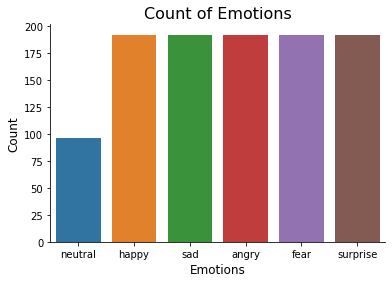

In [12]:
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [13]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [14]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=4)

# taking any example and checking for techniques.
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

In [15]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [16]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [17]:
data, sample_rate 

(array([-2.4280996e-06, -1.2362683e-05, -8.5034850e-07, ...,
        -1.0113516e-11,  5.1403621e-12,  0.0000000e+00], dtype=float32),
 22050)

In [43]:
data.shape

(73574,)

In [44]:
sample_rate

22050

In [14]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [46]:
# Features = pd.DataFrame(X)
# Features['labels'] = Y
# Features.to_csv('/content/gdrive/MyDrive/Colab Notebooks/features.csv', index=False)
# Features.head()

In [18]:
Features = pd.read_csv(r"C:\Users\Joyce Huang\Downloads\BT5153 - Applied Machine Learning for Business Analytics\final-project\features.csv")

In [19]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [20]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [21]:
Y

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [45]:
Y.shape

(3168, 6)

In [22]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2376, 162), (2376, 6), (792, 162), (792, 6))

In [23]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2376, 162), (2376, 6), (792, 162), (792, 6))

In [24]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2376, 162, 1), (2376, 6), (792, 162, 1), (792, 6))

In [25]:
x_train.shape[1]

162

In [12]:
model=Sequential()
model.add(Conv1D(256, kernel_size=8, strides=1, padding='same', activation='tanh', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=4, strides = 4, padding = 'same'))

model.add(Conv1D(256, kernel_size=8, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=4, strides = 4, padding = 'same'))

model.add(Conv1D(128, kernel_size=8, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=4, strides = 4, padding = 'same'))
model.add(Dropout(0.1))

model.add(Conv1D(64, kernel_size=8, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=4, strides = 4, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='tanh'))
model.add(Dropout(0.1))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()
Model: "sequential_1"

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          2304      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 41, 256)           524544    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 11, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 11, 128)           262272    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 3, 128)          

In [13]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=80, epochs=40, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/40
30/30 [==============================] - 3s 79ms/step - loss: 1.6361 - accuracy: 0.2883 - val_loss: 1.5540 - val_accuracy: 0.3510 - lr: 0.0010
Epoch 2/40
30/30 [==============================] - 2s 77ms/step - loss: 1.4825 - accuracy: 0.4057 - val_loss: 1.4147 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 3/40
30/30 [==============================] - 2s 76ms/step - loss: 1.3347 - accuracy: 0.4617 - val_loss: 1.3102 - val_accuracy: 0.4962 - lr: 0.0010
Epoch 4/40
30/30 [==============================] - 2s 75ms/step - loss: 1.2361 - accuracy: 0.5219 - val_loss: 1.2412 - val_accuracy: 0.5177 - lr: 0.0010
Epoch 5/40
30/30 [==============================] - 2s 75ms/step - loss: 1.1090 - accuracy: 0.5673 - val_loss: 1.1359 - val_accuracy: 0.5606 - lr: 0.0010
Epoch 6/40
30/30 [==============================] - 2s 76ms/step - loss: 0.9984 - accuracy: 0.6263 - val_loss: 1.1024 - val_accuracy: 0.5631 - lr: 0.0010
Epoch 7/40
30/30 [==============================] - 2s 79ms/step - loss: 0.8

25/25 [==============================] - 0s 7ms/step - loss: 0.9525 - accuracy: 0.7790
Accuracy of our model on test data :  77.90403962135315 %


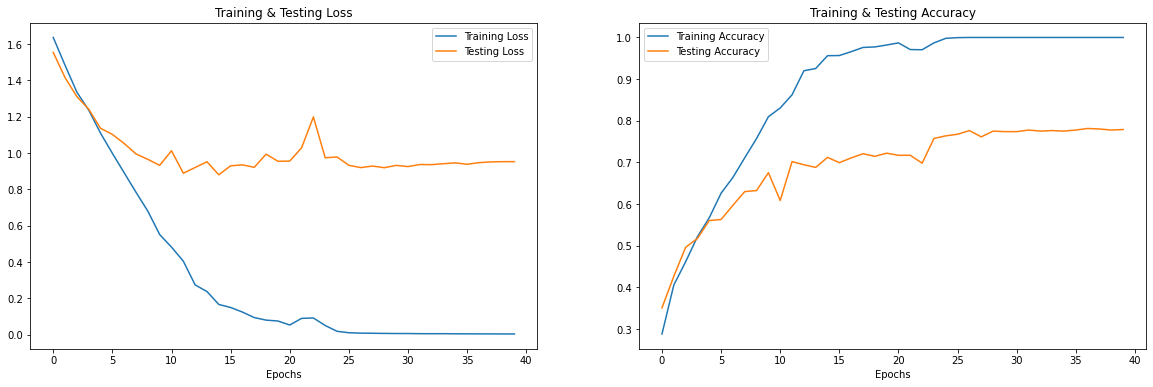

In [14]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(40)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [15]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [16]:
model.save("77model.h5")

In [17]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,sad,surprise
1,angry,angry
2,angry,angry
3,surprise,angry
4,sad,sad
5,neutral,surprise
6,angry,angry
7,angry,angry
8,happy,surprise
9,surprise,surprise


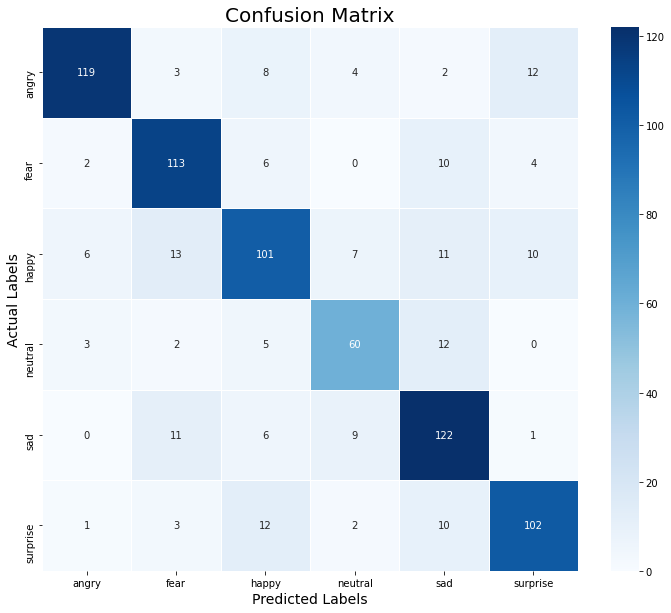

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.91      0.80      0.85       148
        fear       0.78      0.84      0.81       135
       happy       0.73      0.68      0.71       148
     neutral       0.73      0.73      0.73        82
         sad       0.73      0.82      0.77       149
    surprise       0.79      0.78      0.79       130

    accuracy                           0.78       792
   macro avg       0.78      0.78      0.78       792
weighted avg       0.78      0.78      0.78       792



In [2]:
from keras.models import load_model
model = load_model(r'C:\Users\Joyce Huang\Downloads\BT5153 - Applied Machine Learning for Business Analytics\final-project\77model.h5')

In [26]:
pred_test = model.predict(x_test)

In [38]:
x_test.shape
x_test.reshape()

(792, 162, 1)

In [48]:
x_reduce = np.squeeze(x_test, axis=(2,))
x_reduce.shape

(792, 162)

In [70]:
df = pd.DataFrame(x_reduce)
df2 = pd.DataFrame(pred_test)
df2.columns = ['angry','fear','happy','neutral','sad','surprise']

In [71]:
df_pred = pd.concat([df, df2], axis=1)
display(df_pred.head(3))

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,angry,fear,happy,neutral,sad,surprise
0,-0.869042,0.390978,-0.053187,-0.009711,0.070789,0.236571,0.528268,0.142324,0.472663,0.437174,...,-0.302571,-0.290198,-0.228890,-0.185042,0.000466,0.028949,0.007229,0.386752,0.554057,0.022548
1,0.506335,0.174729,-0.940842,-0.775663,-0.467790,-0.240562,-0.636912,-0.743126,-0.307940,-0.589288,...,-0.255526,-0.261464,-0.208520,-0.182816,0.569293,0.000263,0.371317,0.056847,0.000176,0.002104
2,-0.895873,0.537955,0.743812,1.156167,1.601975,0.944988,0.742928,0.501432,0.672732,0.209543,...,1.518587,0.917565,0.177509,-0.145885,0.998569,0.001125,0.000134,0.000082,0.000009,0.000081


In [75]:
y_test_label = encoder.inverse_transform(y_test)
y_test_label

y_pred_label = encoder.inverse_transform(pred_test)
y_pred_label

df_pred['pred_label'] = y_pred_label
df_pred['label'] = y_test_label
display(df_pred.head(3))

,0,1,2,3,4,5,6,7,8,9,...,160,161,angry,fear,happy,neutral,sad,surprise,pred_label,label
0,-0.869042,0.390978,-0.053187,-0.009711,0.070789,0.236571,0.528268,0.142324,0.472663,0.437174,...,-0.228890,-0.185042,0.000466,0.028949,0.007229,0.386752,0.554057,0.022548,sad,surprise
1,0.506335,0.174729,-0.940842,-0.775663,-0.467790,-0.240562,-0.636912,-0.743126,-0.307940,-0.589288,...,-0.208520,-0.182816,0.569293,0.000263,0.371317,0.056847,0.000176,0.002104,angry,angry
2,-0.895873,0.537955,0.743812,1.156167,1.601975,0.944988,0.742928,0.501432,0.672732,0.209543,...,0.177509,-0.145885,0.998569,0.001125,0.000134,0.000082,0.000009,0.000081,angry,angry
